## Data Preparation

In [ ]:
# Import necessary libraries and make necessary arrangements
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
# Import data
df_train=pd.read_csv("train.csv",index_col=0)
df_test =pd.read_csv("test.csv",index_col=0)
df_transactions = pd.read_csv("transactions.csv")
df_stores = pd.read_csv("stores.csv")
df_holidays = pd.read_csv("holidays_events.csv")
df_oil = pd.read_csv("oil.csv")

In [3]:
df_all = df_train.append(df_test)
df_all = df_all.loc[(df_all.store_nbr ==11) & (df_all["family"]=='GROCERY I')]
df_all = df_all.merge(df_stores,left_on="store_nbr",right_on="store_nbr",how="left")
df_holidays = df_holidays.rename(columns = {"type":"Holiday_type"})
df_all = df_all.merge(df_holidays,left_on="date",right_on="date",how="left")
df_all = df_all.merge(df_transactions,left_on=["date","store_nbr"],right_on=["date","store_nbr"],how="left")
df_all = df_all.merge(df_oil,left_on="date",right_on="date",how="left")
df_all = df_all.replace([","," "],"_",regex=True)
df_all = df_all.rename(columns = {"date":"Date"})
df_all["Date"] = df_all["Date"].astype("datetime64")

In [4]:
df_all["family"].unique()

array(['GROCERY_I'], dtype=object)

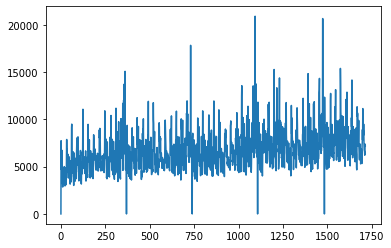

In [5]:
temp = df_all["sales"]
temp.plot()
plt.show()

## SARMIA

In [9]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import pmdarima
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf,pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.tsatools import add_lag
from statsmodels.tsa.stattools import adfuller

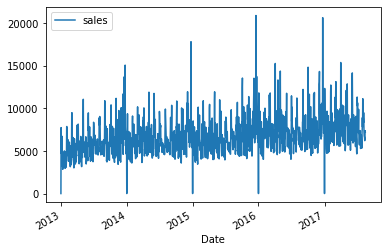

In [10]:
df_arima = df_all[["Date","sales"]][:-16]
df_arima = df_arima.set_index("Date")
df_arima.plot()
plt.show()

<AxesSubplot:ylabel='Frequency'>

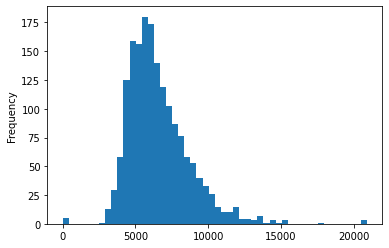

In [23]:
df_arima["sales"].plot.hist(bins=50)

In [11]:
# check stationary 1
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_= adfuller(df_arima)
print("pvalue = ",pvalue," if above 0.05, data is not stationary")

pvalue =  6.359119526699843e-07  if above 0.05, data is not stationary


In [12]:
# check stationary 2
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df_arima)

(0.01, False)

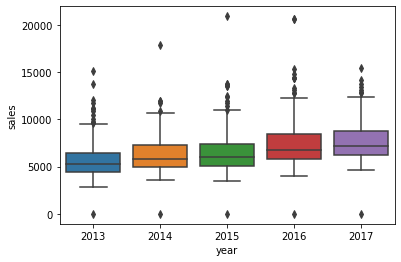

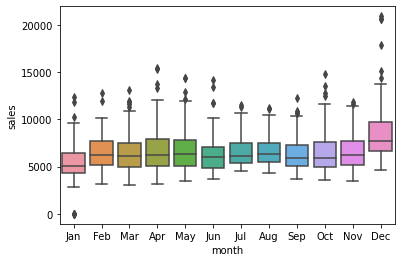

In [13]:
# check seasonality
df_arima['year']=[d.year for d in df_arima.index]
df_arima['month']=[d.strftime("%b") for d in df_arima.index]
years = df_arima['year'].unique()

sns.boxplot(x='year', y ='sales',data=df_arima)
plt.show()
sns.boxplot(x='month', y ='sales',data=df_arima)
plt.show()

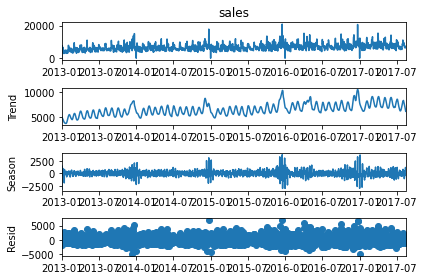

In [14]:
# decompose
from statsmodels.tsa.seasonal import STL,seasonal_decompose
#from statsmodels.tsa.seasonal import MSTL
stl = STL(df_arima["sales"],period=12)
res = stl.fit()
fig = res.plot()
#res.seasonal.plot()

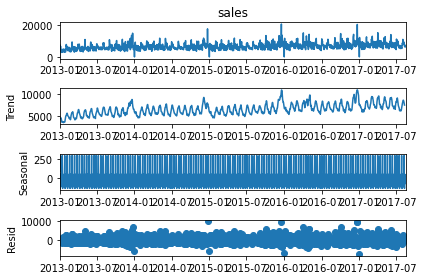

In [24]:
sd = seasonal_decompose(df_arima["sales"],period=12)
fig = sd.plot()
#sd.seasonal.plot()

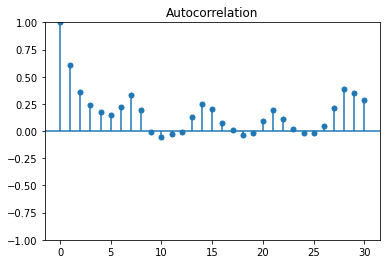

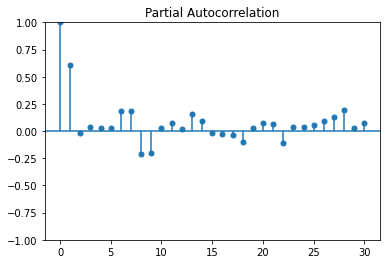

In [25]:
#acf ,pacf
pmdarima.plot_acf(df_arima["sales"],lags=30)
pmdarima.plot_pacf(df_arima["sales"],lags=30)

(-1.1, 1.1)

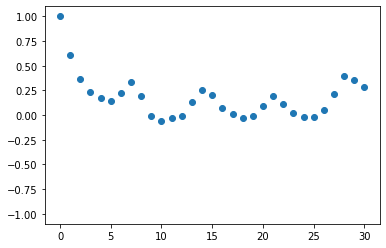

In [26]:
from statsmodels.tsa.stattools import acf

acf_30 =acf(df_arima.sales, nlags=30)
plt.scatter(np.linspace(0,30,31),acf_30)
plt.ylim(-1.1,1.1)

(-1.0, 50.0)

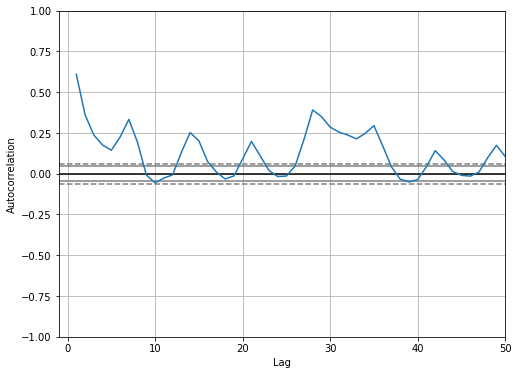

In [27]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(8,6))
autocorrelation_plot(df_arima.sales)
plt.xlim(-1,50)

In [28]:
# caluaclate AIC
from pmdarima.arima import auto_arima

arima_model = auto_arima(df_arima["sales"],start_p=1,start_q=1,
                        max_p = 2,max_q = 2, max_d = 1,m=30,
                        start_P=0,D=1,start_Q=0,max_P=2,max_D=1,max_Q=2,
                        seasonal =True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings = True,
                        stepwise = True, n_fits=2)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[30] intercept   : AIC=30771.951, Time=1.43 sec
 ARIMA(0,0,0)(0,1,0)[30] intercept   : AIC=31146.847, Time=0.33 sec
 ARIMA(1,0,0)(1,1,0)[30] intercept   : AIC=30391.147, Time=19.71 sec
 ARIMA(0,0,1)(0,1,1)[30] intercept   : AIC=inf, Time=45.62 sec
 ARIMA(0,0,0)(0,1,0)[30]             : AIC=31146.021, Time=0.19 sec
 ARIMA(1,0,0)(0,1,0)[30] intercept   : AIC=30820.573, Time=0.64 sec
 ARIMA(1,0,0)(2,1,0)[30] intercept   : AIC=30208.260, Time=164.59 sec
 ARIMA(1,0,0)(2,1,1)[30] intercept   : AIC=inf, Time=398.68 sec
 ARIMA(1,0,0)(1,1,1)[30] intercept   : AIC=inf, Time=49.82 sec
 ARIMA(0,0,0)(2,1,0)[30] intercept   : AIC=30707.844, Time=48.76 sec
 ARIMA(2,0,0)(2,1,0)[30] intercept   : AIC=30195.214, Time=222.21 sec
 ARIMA(2,0,0)(1,1,0)[30] intercept   : AIC=30355.348, Time=25.85 sec
 ARIMA(2,0,0)(2,1,1)[30] intercept   : AIC=inf, Time=454.15 sec
 ARIMA(2,0,0)(1,1,1)[30] intercept   : AIC=inf, Time=55.95 sec
 ARIMA(2,0,1)(2,1,0)[

In [29]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1714
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 30)   Log Likelihood              -15091.607
Date:                            Wed, 29 Jun 2022   AIC                          30195.214
Time:                                    14:47:03   BIC                          30227.788
Sample:                                         0   HQIC                         30207.279
                                           - 1714                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     66.4234     48.998      1.356      0.175     -29.612     162.458
ar.L1          0.5260      0.016     32.512      0.000       0.494       0.558
ar.L2         -0.0955      0.020     -4.822      0.000      -0.134      -0.057
ar.S.L30      -0.6243      0.017    -36.134      0.000      -0.658      -0.590
ar.S.L60      -0.3060      0.016    -18.761      0.000      -0.338      -0.274
sigma2      3.548e+06   6.89e+04     51.464      0.000    3.41e+06    3.68e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2360.76
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
X_train, X_test = df_arima[:-15],df_arima[-15:]

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(X_train.sales,
               oreder = (2,0,0),
               seasonal_order=(2,1,0,30),
                )

result=model.fit()
result.summary()


/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84461D+00    |proj g|=  4.35232D-02


 This problem is unconstrained.



At iterate    5    f=  8.84162D+00    |proj g|=  1.31827D-04

At iterate   10    f=  8.84161D+00    |proj g|=  1.76308D-03

At iterate   15    f=  8.84076D+00    |proj g|=  2.06197D-02

At iterate   20    f=  8.82103D+00    |proj g|=  6.15863D-02

At iterate   25    f=  8.81235D+00    |proj g|=  2.49987D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   2.500D-05   8.812D+00
  F =   8.8123499646371197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                 1699
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 30)   Log Likelihood              -14972.183
Date:                            Wed, 29 Jun 2022   AIC                          29952.365
Time:                                    14:49:24   BIC                          29974.045
Sample:                                         0   HQIC                         29960.399
                                           - 1699                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4836      0.015     33.107      0.000       0.455       0.512
ar.S.L30      -0.6318      0.018    -35.290      0.000      -0.667      -0.597
ar.S.L60      -0.3201      0.017    -19.394      0.000      -0.352      -0.288
sigma2      3.616e+06   6.75e+04     53.599      0.000    3.48e+06    3.75e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.12   Jarque-Bera (JB):              2049.24
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
#Train result
train_prediction = result.predict(X_train.index[0],X_train.index[-1])
#train_prediction = result.predict(0,len(X_train)-1)


<AxesSubplot:xlabel='Date'>

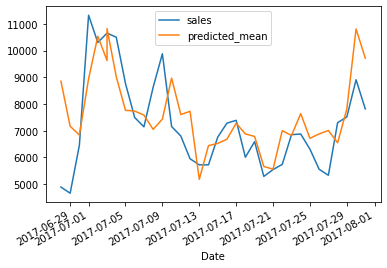

In [34]:
X_train.sales[-35:].plot(legend=True)
train_prediction[-35:].plot(legend=True)

/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


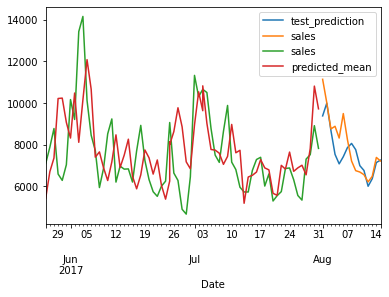

In [36]:
#Test result
test_prediction = result.predict(len(X_train),len(df_arima)-1)
test_prediction = pd.DataFrame({"test_prediction":test_prediction.values},index= X_test.index)
test_prediction.plot(legend=True)
X_test.sales.plot(legend=True)
X_train.sales[-70:].plot(legend=True)
train_prediction[-70:].plot(legend=True)
plt.show()

## SARIMAX

### FFT 

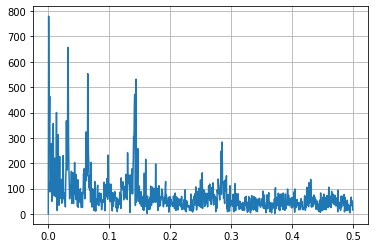

In [37]:
from scipy.fft import fft, fftfreq
# Number of sample points
N = len(df_arima)
# sample spacing
T = 1
x = np.linspace(0.0, N*T, N, endpoint=False)
#y = df_diff.values-df_diff.mean()
y = df_arima["sales"].values-df_arima["sales"].mean()
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()


In [38]:
fft_df = pd.DataFrame({"xf":xf,"yf":2.0/N *np.abs(yf[0:N//2]),"T":1/xf})
fft_df.sort_values("yf",ascending=False).head(10)

,xf,yf,T
1,0.000583,779.809855,1714.000000
55,0.032089,657.004680,31.163636
56,0.032672,590.367615,30.607143
111,0.064761,553.313978,15.441441
247,0.144107,531.621550,6.939271
243,0.141774,471.683563,7.053498
4,0.002334,463.889700,428.500000
2,0.001167,455.577912,857.000000
242,0.141190,424.886507,7.082645
23,0.013419,400.286035,74.521739


### Prepare Fourier Terms

In [135]:
# prepare Fourier terms
L = exog.index.day
f = lambda x: x-15  if x > 15 else x
L = np.array([f(x) for x in L])

exog = pd.DataFrame({'date': df_arima.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin7'] = np.sin(2 * np.pi * exog.index.dayofweek / 7)
exog['cos7'] = np.cos(2 * np.pi * exog.index.dayofweek / 7)
exog['sin7_2'] = np.sin(4 * np.pi * exog.index.dayofweek / 7)
exog['cos7_2'] = np.cos(4 * np.pi * exog.index.dayofweek / 7)
exog['sin15'] = np.sin(2 * np.pi * L / 15)
exog['cos15'] = np.cos(2 * np.pi * L / 15)
exog = exog.drop(columns=['date'])
exog_to_train = exog.iloc[:-15]
exog_to_test = exog.iloc[-15:]


In [107]:
exog.head()

,sin7,cos7,sin7_2,cos7_2,sin15,cos15
date,,,,,,
2013-01-01,0.781831,0.623490,0.974928,-0.222521,0.406737,0.913545
2013-01-02,0.974928,-0.222521,-0.433884,-0.900969,0.743145,0.669131
2013-01-03,0.433884,-0.900969,-0.781831,0.623490,0.951057,0.309017
2013-01-04,-0.433884,-0.900969,0.781831,0.623490,0.994522,-0.104528
2013-01-05,-0.974928,-0.222521,0.433884,-0.900969,0.866025,-0.500000


In [ ]:
arima_exog_model = auto_arima(df_arima["sales"], exogenous=exog, seasonal=True, m=30,trace=True)

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_exog = SARIMAX(X_train.sales,
                exog = exog_to_train.values,
                oreder = (2,0,0),
                seasonal_order=(2,1,0,30),
                )

result_exog = model_exog.fit()

/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65903D+00    |proj g|=  2.09870D-02

At iterate    5    f=  8.65844D+00    |proj g|=  1.68907D-04

At iterate   10    f=  8.65841D+00    |proj g|=  4.42069D-03

At iterate   15    f=  8.65496D+00    |proj g|=  4.51029D-02

At iterate   20    f=  8.63668D+00    |proj g|=  5.81750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     23     26      1     0     0   1.479D-05   8.637D+00
  F =   8.6366495794248781     

CONVERG

In [58]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                 1699
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 30)   Log Likelihood              -14673.668
Date:                            Wed, 29 Jun 2022   AIC                          29367.335
Time:                                    15:33:28   BIC                          29421.535
Sample:                                         0   HQIC                         29387.419
                                           - 1699                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -822.2731     62.251    -13.209      0.000    -944.283    -700.263
x2           777.2004     57.666     13.478      0.000     664.177     890.224
x3          -419.6532     38.388    -10.932      0.000    -494.892    -344.415
x4          -419.5286     36.316    -11.552      0.000    -490.707    -348.350
x5           927.3588    143.301      6.471      0.000     646.494    1208.223
x6          -238.2545    139.626     -1.706      0.088    -511.917      35.408
ar.L1          0.4553      0.011     39.823      0.000       0.433       0.478
ar.S.L30      -0.5778      0.013    -45.431      0.000      -0.603      -0.553
ar.S.L60      -0.2800      0.014    -19.809      0.000      -0.308      -0.252
sigma2      2.521e+06   3.54e+04     71.131      0.000    2.45e+06    2.59e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.10   Jarque-Bera (JB):             12664.46
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
#Train result
train_prediction_exog = result_exog.predict(X_train.index[0],X_train.index[-1],exogenous=exog_to_train)
#train_prediction = result.predict(0,len(X_train)-1)


<AxesSubplot:xlabel='Date'>

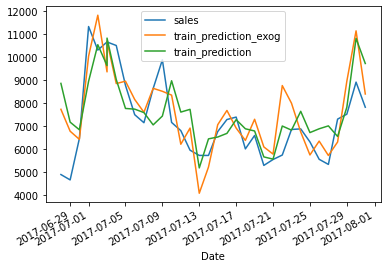

In [91]:
X_train.sales[-35:].plot(legend=True)
train_prediction_exog[-35:].plot(legend=True,label="train_prediction_exog")
train_prediction[-35:].plot(legend=True,label="train_prediction")


/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


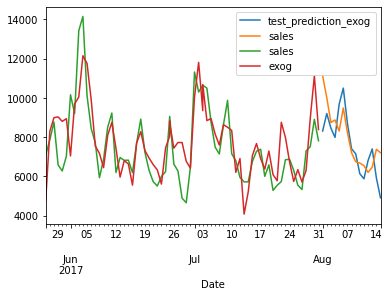

In [105]:
#Test result
test_prediction_exog = result_exog.predict(len(X_train),len(df_arima)-1,exog=exog_to_test)
test_prediction_exog = pd.DataFrame({"test_prediction_exog":test_prediction_exog.values},index= X_test.index)
ax = test_prediction_exog.plot(legend=True)
#test_prediction.plot(legend=True,ax=ax)
X_test.sales.plot(legend=True)
X_train.sales[-70:].plot(legend=True)
train_prediction_exog[-70:].plot(legend=True,label = "exog")
#train_prediction[-70:].plot(legend=True)
plt.show()

### Fourier Terms + features

In [131]:
# prepare Fourier terms
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

L = exog.index.day
f = lambda x: x-15  if x > 15 else x
L = np.array([f(x) for x in L])

exog = pd.DataFrame({'date': df_arima.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog["promotion"] = scaler.fit_transform(df_all["onpromotion"][:-16].values.reshape(-1,1))
exog['sin7'] = np.sin(2 * np.pi * exog.index.dayofweek / 7)
exog['cos7'] = np.cos(2 * np.pi * exog.index.dayofweek / 7)
exog['sin7_2'] = np.sin(4 * np.pi * exog.index.dayofweek / 7)
exog['cos7_2'] = np.cos(4 * np.pi * exog.index.dayofweek / 7)
exog['sin15'] = np.sin(2 * np.pi * L / 15)
exog['cos15'] = np.cos(2 * np.pi * L / 15)
exog = exog.drop(columns=['date'])
exog_to_train_promo = exog.iloc[:-15]
exog_to_test_promo = exog.iloc[-15:]
# Fit model
#arima_exog_model = auto_arima(y=y_to_train, exogenous=exog_to_train, seasonal=True, m=30)
# Forecast
#y_arima_exog_forecast = arima_exog_model.predict(n_periods=365, exogenous=exog_to_test)



In [111]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_exog_promo = SARIMAX(X_train.sales,
                exog = exog_to_train_promo.values,
                oreder = (2,0,0),
                seasonal_order=(2,1,0,30),
                )

result_exog_promo = model_exog_promo.fit()

/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.64671D+00    |proj g|=  2.49593D-02

At iterate    5    f=  8.64603D+00    |proj g|=  1.40400D-04

At iterate   10    f=  8.64602D+00    |proj g|=  3.52896D-03

At iterate   15    f=  8.64451D+00    |proj g|=  3.84744D-02

At iterate   20    f=  8.62653D+00    |proj g|=  4.18397D-02

At iterate   25    f=  8.62515D+00    |proj g|=  9.90212D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     25     28      1     0     0   

In [112]:
result_exog_promo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                 1699
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 30)   Log Likelihood              -14654.134
Date:                            Wed, 29 Jun 2022   AIC                          29330.269
Time:                                    16:12:49   BIC                          29389.889
Sample:                                         0   HQIC                         29352.361
                                           - 1699                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3406.4581    316.397     10.766      0.000    2786.332    4026.585
x2          -828.7804     62.209    -13.323      0.000    -950.708    -706.853
x3           778.1110     58.010     13.413      0.000     664.413     891.809
x4          -412.8689     37.831    -10.914      0.000    -487.016    -338.722
x5          -411.9620     35.073    -11.746      0.000    -480.704    -343.220
x6           897.7373    140.764      6.378      0.000     621.845    1173.630
x7          -211.4800    139.015     -1.521      0.128    -483.944      60.984
ar.L1          0.4531      0.012     38.075      0.000       0.430       0.476
ar.S.L30      -0.5676      0.013    -43.945      0.000      -0.593      -0.542
ar.S.L60      -0.2909      0.015    -19.664      0.000      -0.320      -0.262
sigma2      2.463e+06   3.56e+04     69.210      0.000    2.39e+06    2.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.62   Jarque-Bera (JB):             11362.56
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             1.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [113]:
#Train result
train_prediction_exog_promo = result_exog_promo.predict(X_train.index[0],X_train.index[-1],exogenous=exog_to_train_promo)
#train_prediction = result.predict(0,len(X_train)-1)


<AxesSubplot:xlabel='Date'>

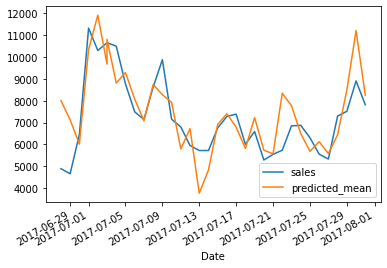

In [114]:
X_train.sales[-35:].plot(legend=True)
train_prediction_exog_promo[-35:].plot(legend=True)

/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


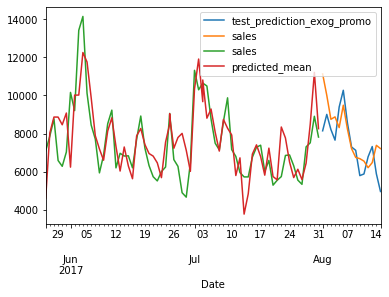

In [129]:
#Test result
test_prediction_exog_promo = result_exog_promo.predict(len(X_train),len(df_arima)-1,exog=exog_to_test)
test_prediction_exog_promo = pd.DataFrame({"test_prediction_exog_promo":test_prediction_exog_promo.values},index= X_test.index)
test_prediction_exog_promo.plot(legend=True)
X_test.sales.plot(legend=True)
X_train.sales[-70:].plot(legend=True)
train_prediction_exog_promo[-70:].plot(legend=True)
plt.show()

/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


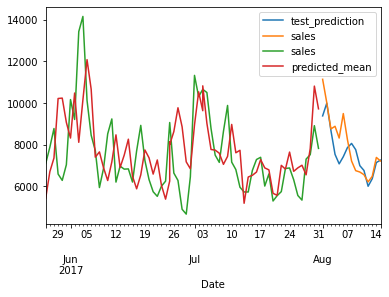

/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


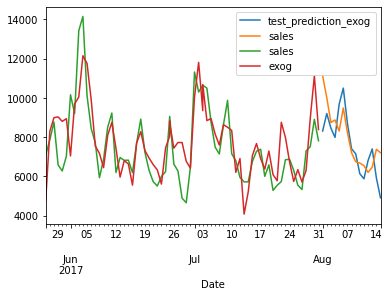

/opt/anaconda3/envs/c_shweng_python39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


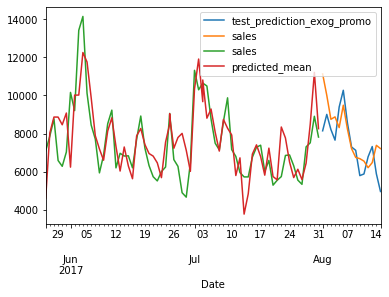

In [137]:
#Test result
test_prediction = result.predict(len(X_train),len(df_arima)-1)
test_prediction = pd.DataFrame({"test_prediction":test_prediction.values},index= X_test.index)
test_prediction.plot(legend=True)
X_test.sales.plot(legend=True)
X_train.sales[-70:].plot(legend=True)
train_prediction[-70:].plot(legend=True)
plt.show()

#Test result
test_prediction_exog = result_exog.predict(len(X_train),len(df_arima)-1,exog=exog_to_test)
test_prediction_exog = pd.DataFrame({"test_prediction_exog":test_prediction_exog.values},index= X_test.index)
ax = test_prediction_exog.plot(legend=True)
#test_prediction.plot(legend=True,ax=ax)
X_test.sales.plot(legend=True)
X_train.sales[-70:].plot(legend=True)
train_prediction_exog[-70:].plot(legend=True,label = "exog")
#train_prediction[-70:].plot(legend=True)
plt.show()

#Test result
test_prediction_exog_promo = result_exog_promo.predict(len(X_train),len(df_arima)-1,exog=exog_to_test_promo)
test_prediction_exog_promo = pd.DataFrame({"test_prediction_exog_promo":test_prediction_exog_promo.values},index= X_test.index)
test_prediction_exog_promo.plot(legend=True)
X_test.sales.plot(legend=True)
X_train.sales[-70:].plot(legend=True)
train_prediction_exog_promo[-70:].plot(legend=True)
plt.show()